# Time Series Tutorial
10/10/17

We will work through this tutorial in class to hone skills in working with time series.

In [1]:
from scipy import interpolate
from scipy import signal
from scipy import stats

# Import numerical tools
import numpy as np

# Import pyplot for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

# Import statistical tools
from scipy import stats
np.random.seed(12345678) #If you specify a random seed, it will initialize the random number
    #generator the same way each time, making your results reproducible each time you rerun
    #the code. Note that multiple draws of a random number within the same session will still 
    #return different values.

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

%config InlineBackend.figure_formats = {'svg',}
#%config InlineBackend.figure_formats = {'png', 'retina'}

#Import pandas for reading in and managing data
import pandas as pd

#Import seaborn (useful for plotting - makes plots pretty)
import seaborn as sns

In [2]:
help(interpolate.interp1d)

Help on class interp1d in module scipy.interpolate.interpolate:

class interp1d(scipy.interpolate.polyint._Interpolator1D)
 |  Interpolate a 1-D function.
 |  
 |  `x` and `y` are arrays of values used to approximate some function f:
 |  ``y = f(x)``.  This class returns a function whose call method uses
 |  interpolation to find the value of new points.
 |  
 |  Parameters
 |  ----------
 |  x : (N,) array_like
 |      A 1-D array of real values.
 |  y : (...,N,...) array_like
 |      A N-D array of real values. The length of `y` along the interpolation
 |      axis must be equal to the length of `x`.
 |  kind : str or int, optional
 |      Specifies the kind of interpolation as a string
 |      ('linear', 'nearest', 'zero', 'slinear', 'quadratic, 'cubic'
 |      where 'slinear', 'quadratic' and 'cubic' refer to a spline
 |      interpolation of first, second or third order) or as an integer
 |      specifying the order of the spline interpolator to use.
 |      Default is 'linear'.
 

In [3]:
fname = '/Users/lglarsen/Downloads/Student_Datasets-patch-4-206e7b656442d9024d2cffa9e7976be199909d23/Chen_EastRiver.csv'
df = pd.read_csv(fname)
df.head()

Date  Discharge     DIC    DOC          Ca         Na          Mg  \
0  2-May-2014       4.65  2333.7  147.6  1219.30000  67.124783  333.538272   
1  3-May-2014       5.11  2322.5  158.8         NaN        NaN         NaN   
2  4-May-2014       6.26  2096.3  171.4  1041.72825  59.946087  297.021811   
3  5-May-2014       7.45  2020.0  188.5         NaN        NaN         NaN   
4  6-May-2014       8.09  2003.3  193.7         NaN        NaN         NaN   

           K         Si     Cl    SO4   NO3  
0  12.893077  79.048214  245.8  395.4  48.2  
1        NaN        NaN   80.2  388.6  50.4  
2  12.252051  74.535714   86.4  298.5  13.0  
3        NaN        NaN   45.6  271.1  15.1  
4        NaN        NaN   57.9  255.9  12.4

In [4]:
date = df['Date']
Cl = df['Cl']
Cl[np.isnan(Cl)] = 0 # This is a lazy way to fill gaps
daycounter = np.arange(1., len(Cl)+1.) # A counter for day number. This strategy could backfire 
# if the data record is missing any days!

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Now let's say we want to obtain an hourly time series from our data. Below we'll compare different strategies for interpolation. But first let's develop the "x" array to which we want to interpolate.

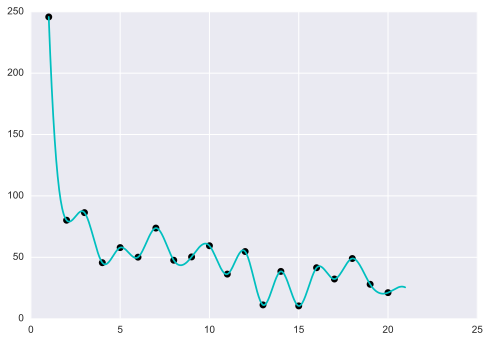

In [5]:
hour = np.arange(1,len(Cl)+0.001, 1./24) # Hourly array

# CREATE INTERPOLATION FUNCTIONS
f1 = interpolate.interp1d(daycounter, Cl, 'linear', bounds_error=False, fill_value='extrapolate')
f2 = interpolate.interp1d(daycounter, Cl, 'nearest', bounds_error=False, fill_value='extrapolate')
f3 = interpolate.interp1d(daycounter, Cl, 'zero', bounds_error=False, fill_value=Cl[len(Cl)-1])
f4 = interpolate.interp1d(daycounter, Cl, 'slinear', bounds_error=False, fill_value=Cl[len(Cl)-1])
f5 = interpolate.interp1d(daycounter, Cl, 'quadratic', bounds_error=False, fill_value=Cl[len(Cl)-1])
f6 = interpolate.interp1d(daycounter, Cl, 'cubic', bounds_error=False, fill_value=Cl[len(Cl)-1])
#f7 = interpolate.Pchipinterpolator(daycounter, Cl, extrapolate=True)

# APPLY INTERPOLATION FUNCTIONS
Cl1 = f1(hour)
Cl2 = f2(hour)
Cl3 = f3(hour)
Cl4 = f4(hour)
Cl5 = f5(hour)
Cl6 = f6(hour)
#Cl7 = f7(hour)

# PLOT RESULTS
plt.plot(daycounter[0:20], (Cl[0:20]), 'ko')
#plt.plot(hour[0:20*24], (Cl1[0:20*24]), 'r-')
#plt.plot(hour[0:20*24], (Cl2[0:20*24]), 'b-')
#plt.plot(hour[0:20*24], (Cl3[0:20*24]), 'g-')
#plt.plot(hour[0:20*24], (Cl4[0:20*24]), 'y-')
#plt.plot(hour[0:20*24], (Cl5[0:20*24]), 'm-')
plt.plot(hour[0:20*24], (Cl6[0:20*24]), 'c-')
#plt.plot(hour[0:20*24], Cl7[0:20*24], 'w-')
plt.show()

Let's now illustrate a few detrending techniques... For purposes of illustration, we'll exclude the first "high" point above and look at the other points in this abbreviated time series.

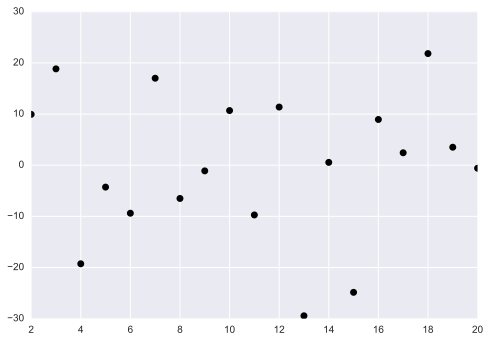

In [6]:
Cl_detrend = signal.detrend(Cl[1:20])
plt.plot(daycounter[1:20], Cl_detrend, 'ko')

We can calculate the moving average using a command in Pandas...

In [7]:
Cl_MA = Cl.rolling(window=3).mean() # This will compute a three-point moving average.
Cl_MA.head()

0           NaN
1           NaN
2    137.466667
3     70.733333
4     63.300000
Name: Cl, dtype: float64

Notice that the first two entries are NaN. What does this tell you about how the moving average function is working?

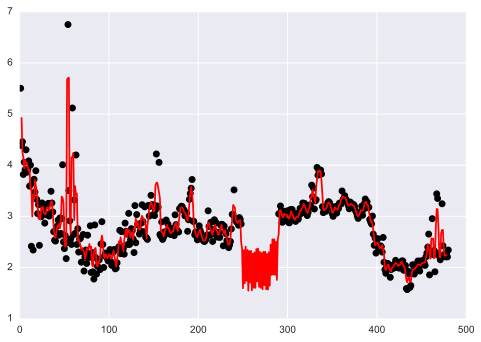

In [8]:
plt.plot(daycounter, np.log(Cl), 'ko')
plt.plot(daycounter[1:len(daycounter)-2], np.log(Cl_MA[2:len(daycounter)-1]), 'r-')

Now plot the detrended version...

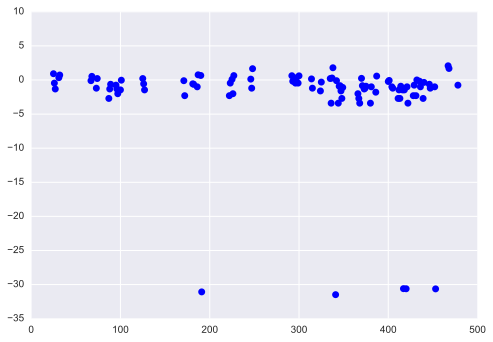

In [9]:
Cl_MAdetrend = Cl.values[1:len(Cl)-1]-Cl_MA.values[2:len(Cl_MA)] #We need to use the .values argument, because keeping
    # Cl as a data frame preserves its indices, and here, we want to change its indices.
plt.plot(daycounter[1:len(daycounter)-1], np.log(Cl_MAdetrend), 'bo')

Let's now evaluate the removal of trends through differencing:

In [10]:
Cl_diff = np.diff(Cl)
print(np.shape(Cl))
print(np.shape(Cl_diff))

(480,)
(479,)


Note that the differenced array is one element smaller than the non-differenced array.

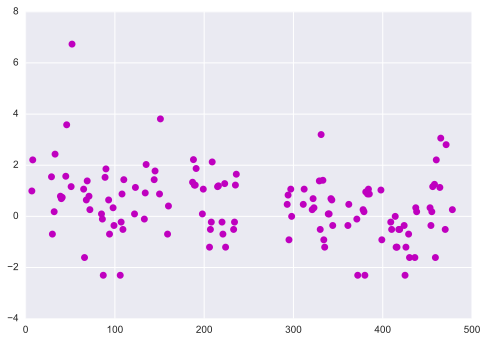

In [11]:
plt.plot(np.log(Cl_diff), 'mo')
plt.show()

And the second difference...

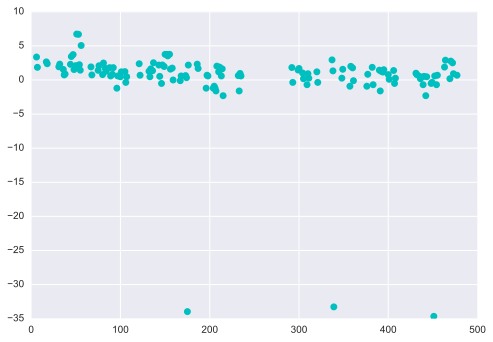

In [12]:
plt.plot(np.log(np.diff(Cl, 2)), 'co')
plt.show()

Last, let's plot the autocorrelation of the chloride time series...

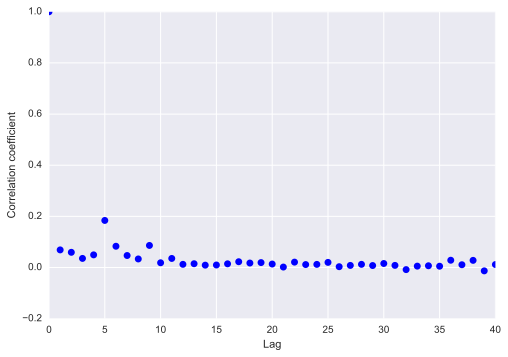

In [13]:
from statsmodels.tsa.stattools import acf #TSA is the time-series analysis library.
acf_Cl = acf(Cl)
plt.plot(acf_Cl, 'bo')
plt.xlabel('Lag')
plt.ylabel('Correlation coefficient')
plt.show()

Last, let's look at the cross-correlation between Cl and DOC. First, let's grab the DOC column and fill the gaps.

In [14]:
DOC = df['DOC']
DOC[np.isnan(DOC)] = 0 # Again, we will fill gaps in a lazy way.


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


The following block of code that I wrote crops the arrays to the same size after performing a shift and then calculates the cross-correlation directly from the formula I presented in class. I wrote it to verify that the xcorr_maxlag function below that I downloaded from the internet works properly. It does! 

In [15]:
Y1 = np.array([1., 2., 3.])
Y2 = np.array([0, 1, 0.5])
lag = -1.
if lag >= 0:
    X2 = Y2[0:len(Y2)-lag]
    X1 = Y1[lag:]
else:
    if lag < 0:
        X2 = Y2[-lag:]
        X1 = Y1[0:len(Y1)+lag]
nstar = len(Y1)-np.abs(lag)
xcor = (nstar*np.sum(X1*X2)-np.sum(X1)*np.sum(X2))/np.sqrt((nstar*np.sum(X1*X1)-(np.sum(X1))**2)*(nstar*np.sum(X2*X2)-(np.sum(X2))**2))

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [16]:
print(xcor)
print(X1)
print(X2)

-1.0
[ 1.  2.]
[ 1.   0.5]


And below is the function that I downloaded from the internet that I would like to check. Once we execute this block of code, we can use it like any other function, as I do in the cell below it.

In [17]:
def xcorr_maxlag(x, y, maxlag=1.0):
    """
    Compute the cross-correlogram of two time series.
    """
    xl = x.size
    yl = y.size

    c = np.zeros(2*maxlag + 1)

    for i in range(maxlag+1):
        tmp = np.corrcoef(x[0:min(xl, yl-i)], y[i:i+min(xl, yl-i)])
        c[maxlag-i] = tmp[1][0]
        tmp = np.corrcoef(x[i:i+min(xl-i, yl)], y[0:min(xl-i, yl)])
        c[maxlag+i] = tmp[1][0]

    return c

In [18]:
c = xcorr_maxlag(Y1, Y2, 1)
print(c)

[-1.   0.5  1. ]


Getting back to the problem at hand, let us now evaluate the cross-correlation between DOC and Cl. We might expect them to be highly correlated at lag 0 if DOC behaves conservatively but have a cross-correlation function that looks a bit like the autocorrelation function above.

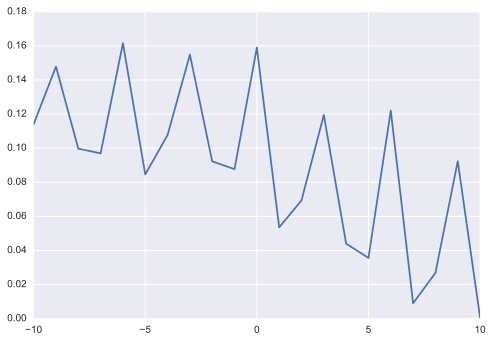

In [19]:
maxlag = 10
xcorr = xcorr_maxlag(Cl.values, DOC.values, maxlag)
plt.plot(np.arange(-maxlag, maxlag+1), xcorr)

We can invert the formula for the significance test given in Davis to plot required significance levels for the cross correlation at the $\alpha$ = 0.05 level. This test, however, assumes that the underlying distributions are normal. We can see through inspection that the log transforms are approximately normal.

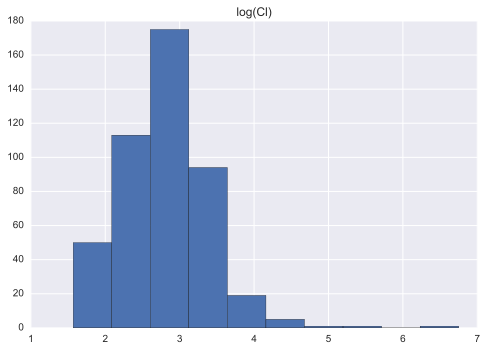

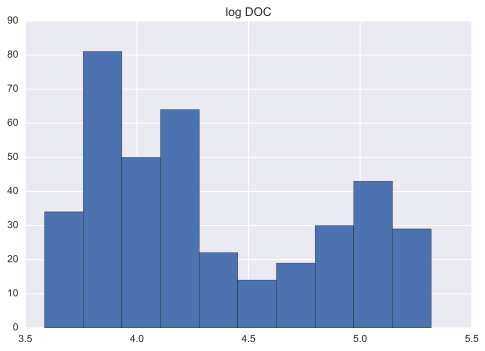

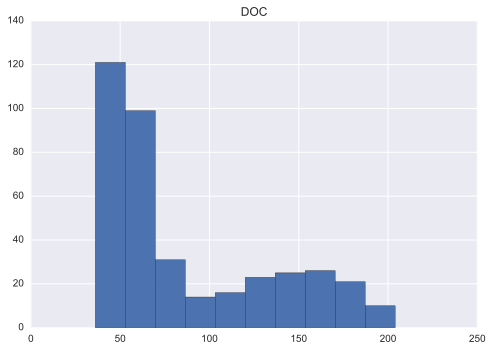

In [20]:
plt.hist(np.log(Cl.values[Cl.values>0])) # Plot the histogram of the log of Cl for only those values greater than zero (since we'd
     #earlier set NaNs equal to zero).
plt.title('log(Cl)')
plt.show()
plt.hist(np.log(DOC.values[DOC.values>0]))
plt.title('log DOC')
plt.show()
plt.hist(DOC.values[DOC.values>0])
plt.title('DOC')
plt.show()

There isn't much we can do about the bimodal DOC to transform it to something normal. A Box-Cox transformation might work, but let's first of all see how close to the significance threshold these cross-correlations are before making the decision to go down such a complicated route.

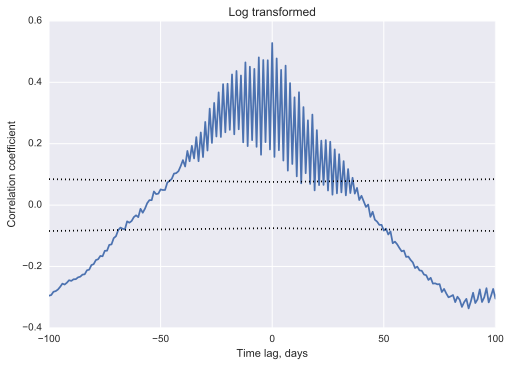

In [21]:
maxlag = 100
lags = np.arange(-maxlag,maxlag+1)
crit_t = stats.t.ppf(0.95, np.min([len(DOC), len(Cl)])-np.abs(lags)-2) # The second argument is n*-2, where n* is the
        # number of overlapping points
crit_r = crit_t*np.sqrt(1/(np.min([len(DOC), len(Cl)])-np.abs(lags)-2+crit_t**2))
logCl = np.log(Cl.values) 
logDOC = np.log(DOC.values)
logCl[~np.isfinite(logCl)]= 0 #Again, use the lazy woman trick of setting -Infs (from taking the log of 0) to 0.
logDOC[~np.isfinite(logDOC)]=0
xcorr = xcorr_maxlag(logCl, logDOC, maxlag)
plt.plot(lags, xcorr)
plt.plot(lags, crit_r, 'k:')
plt.plot(lags, -crit_r, 'k:')
plt.title('Log transformed')
plt.xlabel('Time lag, days')
plt.ylabel('Correlation coefficient')
plt.show()

For comparison, let's do this analysis without taking the log transform.

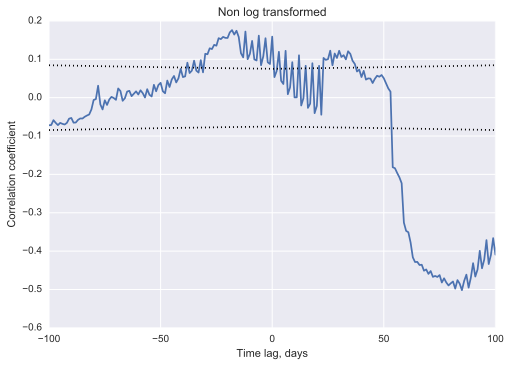

In [22]:
xcorr = xcorr_maxlag(Cl.values, DOC.values, maxlag)
plt.plot(lags, xcorr)
plt.plot(lags, crit_r, 'k:')
plt.plot(lags, -crit_r, 'k:')
plt.title('Non log transformed')
plt.xlabel('Time lag, days')
plt.ylabel('Correlation coefficient')
plt.show()

How do you interpret these discrepancies? Perhaps a wider array of autocorrelation plots, with significance levels, would be informative...

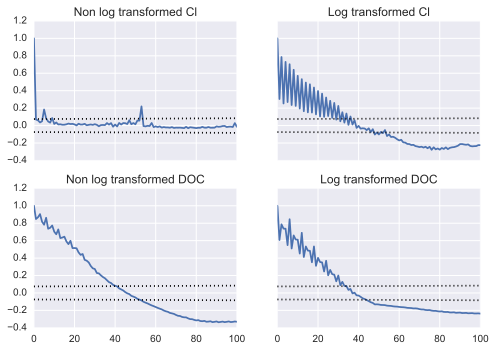

In [23]:
z_crit = stats.norm.ppf(0.95) #Critical z-score for 95% confidence level
acf_lags= np.arange(0,maxlag+1)
acf_crit_r = z_crit/np.sqrt(len(DOC)-acf_lags+3)

f, ax = plt.subplots(2,2, sharex=True, sharey=True) # Set up a plot matrix where x- and y-axes are shared.
ax[0,0].plot(acf(Cl.values, nlags=100))
ax[0,0].plot(acf_lags, acf_crit_r, 'k:')
ax[0,0].plot(acf_lags, -acf_crit_r, 'k:')
ax[0,0].set_title('Non log transformed Cl')
ax[0,1].plot(acf(logCl, nlags=100))
ax[0,1].plot(acf_lags, acf_crit_r, 'k:')
ax[0,1].plot(acf_lags, -acf_crit_r, 'k:')
ax[0,1].set_title('Log transformed Cl')
ax[1,0].plot(acf(DOC.values, nlags=100))
ax[1,0].plot(acf_lags, acf_crit_r, 'k:')
ax[1,0].plot(acf_lags, -acf_crit_r, 'k:')
ax[1,0].set_title('Non log transformed DOC')
ax[1,1].plot(acf(logDOC, nlags=100))
ax[1,1].plot(acf_lags, acf_crit_r, 'k:')
ax[1,1].plot(acf_lags, -acf_crit_r, 'k:')
ax[1,1].set_title('Log transformed DOC')


This makes me suspect there is a smooth seasonal trend in DOC and Cl that we might want to take out, because seasonal variability is an exogenous factor that might override the other dependencies between variables that we're looking for. But we haven't even plotted the full time series yet! Let's do so.

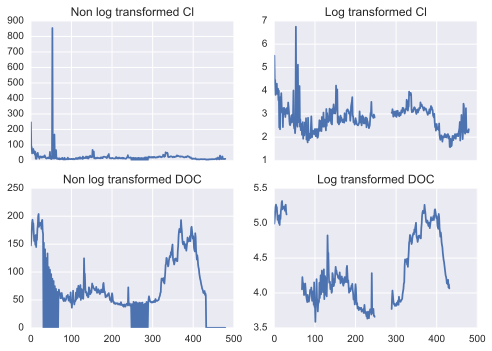

In [24]:
f, ax = plt.subplots(2,2, sharex=True)
ax[0,0].plot(Cl)
ax[0,0].set_title('Non log transformed Cl')
ax[0,1].plot(np.log(Cl))
ax[0,1].set_title('Log transformed Cl')
ax[1,0].plot(DOC)
ax[1,0].set_title('Non log transformed DOC')
ax[1,1].plot(np.log(DOC))
ax[1,1].set_title('Log transformed DOC')

Finally, note that you can repeat these analyses for any other two columns of variables easily, by setting "Cl" and "DOC" equal to different columns where they are first defined in the beginning (keeping the variable names "Cl" and "DOC." You could then reexecute all cells under the Cell menu.

## Fourier Analysis of Signals

For this part of the tutorial, we will be working with a classic dataset--a time series of sunspots starting with year 1700.

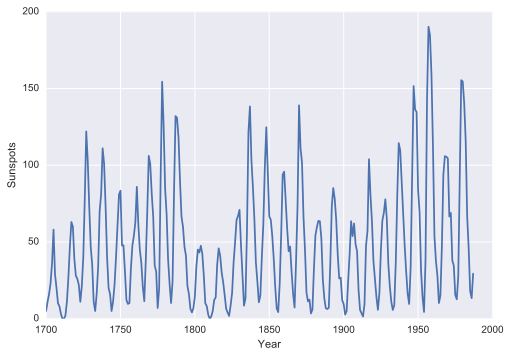

In [25]:
filename = '/Users/lglarsen/Dropbox/GEOG 279 F2017/sunspots.csv'
ss = pd.read_csv(filename)
plt.plot(ss['Year'], ss['Sunspots'])
plt.xlabel('Year'), plt.ylabel('Sunspots')
plt.show()

Let's now obtain a stem plot of the discrete Fourier transform, which will tell us roughly how important each *observed* frequency is to our overall signal. (We can only observe a discrete number of frequencies with discrete observations.) Note that it is important to first subtract the mean of the signal *before* doing the Fourier transform. Otherwise, we will end up with a large component at zero frequency that reflects the fact that a lot of the information about the signal is in its mean. (You can verify on your own by taking out the mean subtraction below.)

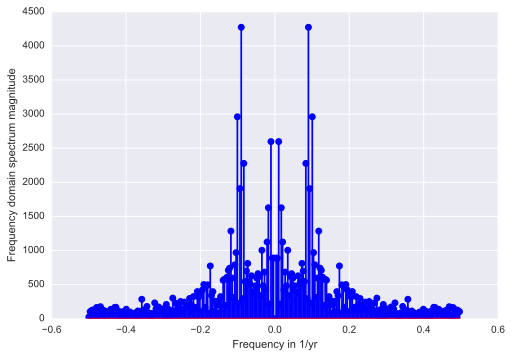

In [26]:
from scipy import fftpack

SS =  fftpack.fft(ss['Sunspots']-np.mean(ss['Sunspots'])) # The discrete Fourier transform of the sunspots time series, equal to the mean of 
    # the sine and cosine coefficients for each frequency.
f_s = 1. #The frequency of our observations, here 1/year
freqs = fftpack.fftfreq(len(ss['Sunspots']))*f_s # The frequencies corresponding to each of the values in SS.
plt.stem(freqs, np.abs(SS))
plt.xlabel('Frequency in 1/yr')
plt.ylabel('Frequency domain spectrum magnitude')
plt.show()

We see that the spectrum is symmetric and hence contains redundant information. Hence, it is better to just plot the first half of the spectrum.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


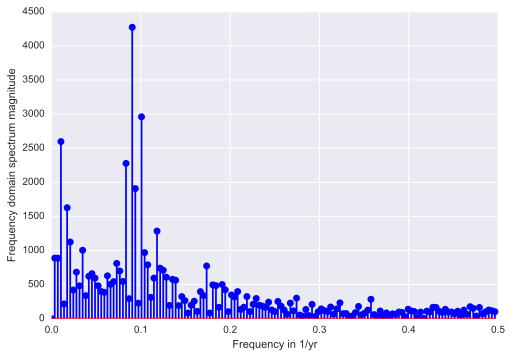

In [27]:
plt.stem(freqs[0:len(freqs)/2], abs(SS[0:len(SS)/2]))
plt.xlabel('Frequency in 1/yr')
plt.ylabel('Frequency domain spectrum magnitude')
plt.show()

Notice that this plot goes up to the Nyquist frequency, which is half the frequency of our observations (1/yr). This means that the highest frequency signal we are able to resolve is two-year cycles.

From the plot above, we see that the dominant period of the sunspots is a little more than 10 years (i.e., dominant frequency is a little less than 1/10).

We can also plot the phase of the Fourier spectrum, which gives us information about how each of the constituent sinusoids are positioned in time relative to each other. (In other words, the phase tells us how far along the time axis the sinusoids should be translated). We can do this by applying the `np.angle` command directly to the FFT output.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


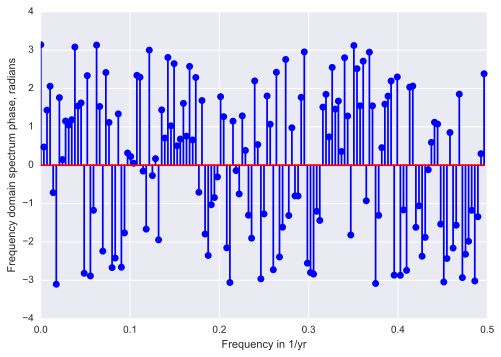

In [28]:
plt.stem(freqs[0:len(freqs)/2], np.angle(SS[0:len(SS)/2]))
plt.xlabel('Frequency in 1/yr')
plt.ylabel('Frequency domain spectrum phase, radians')
plt.show()

Phase information is often used to reconstruct synthetic time series with the sample constituent properties (i.e., same amount of power in each frequency), but in which the phases are shuffled randomly (using `np.random.shuffle`). These phase-shuffled time series can then be used in Monte Carlo tests of significance. You can reuse this code below to do this for any time series.

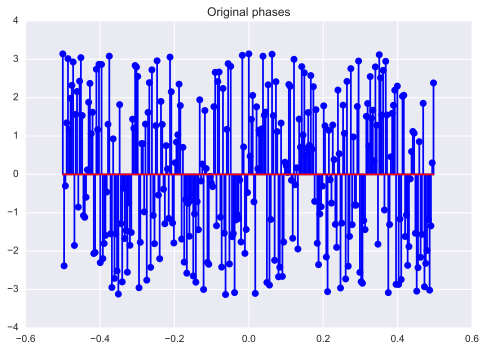

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


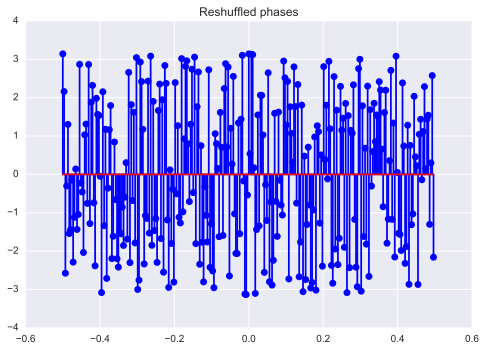

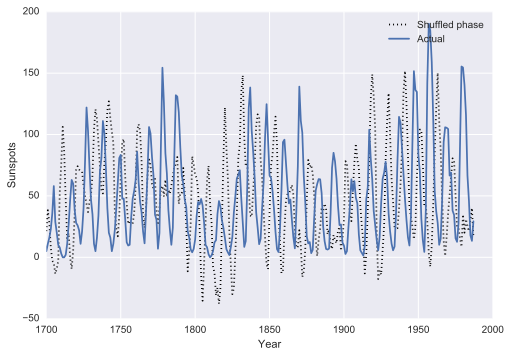

In [29]:
from numpy import random
Phase = np.angle(SS)
plt.stem(freqs, Phase)
plt.title('Original phases')
plt.show()
half_phase = Phase[1:len(freqs)/2] # The only non-redundant information. The other half is mirrored across the y-axis
   # and negative, and we need to preserve this in the reshuffling.
random.shuffle(half_phase) #Shuffle the half phase in place and overwrites it
new_phase = np.append(np.append(Phase[0], half_phase), np.append(Phase[0], -half_phase[::-1])) # The indexing in
    # the second term reverses (mirrors) the array
plt.stem(freqs, new_phase)
plt.title('Reshuffled phases')
plt.show()
mag = np.abs(SS)
new_TS = np.real(fftpack.ifft(mag*np.exp(-new_phase*1j))) #In Python, j is used for he imaginary number i, only j==-i. Confusing!
plt.plot(ss['Year'], new_TS+np.mean(ss['Sunspots']), 'k:')
plt.plot(ss['Year'], ss['Sunspots'])
plt.legend(['Shuffled phase', 'Actual'])
plt.xlabel('Year')
plt.ylabel('Sunspots')
plt.show()

You can see here that this approach isn't flawless, as it results in some negative sunspots, even after adding the mean back in.

## Power spectrum

Let's now come up with an estimate of the power spectral density, aka power spectrum. The command we'll use is `mlab.psd`. Here, we want to pad the array to the nearest power of two. First, we'll get the raw spectrum, and then we'll illustrate how to smooth it using Welch's method.

### Raw power spectrum

The sunspot array is 288 entries long. The next highest power of two is 2^9, which is 512. Thus, for a raw power spectrum, we should use NFFT = 288 (the actual number of entries) and specify a `pad_to` of 512. The `Fs`, or measurement frequency, should be specified as 1 (i.e., 1/year). Note that we can subtract the mean out by setting `detrend=mlab.detrend_mean`.

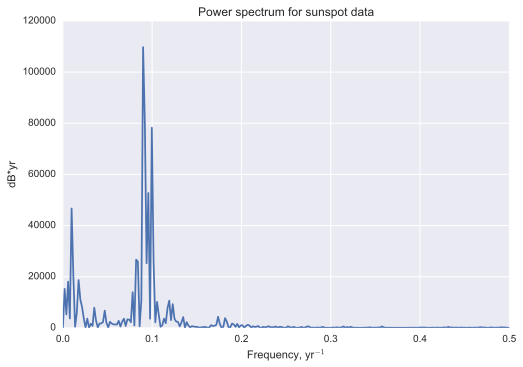

In [30]:
from matplotlib import mlab
power_x, freq_x = mlab.psd(ss['Sunspots'], 288, Fs=1, detrend=mlab.detrend_mean, pad_to=512, window=mlab.window_none, noverlap=0)
plt.plot(freq_x, power_x)
plt.xlabel('Frequency, yr$^{-1}$')
plt.ylabel('dB*yr') #The output is power in dB (decibles) per frequency
plt.title('Power spectrum for sunspot data')
plt.show()

We can see the two dominant periods identified from the periodogram, but there is still a lot of noise.

To smooth this spectrum using Welch's approach, we need to use at least two overlapping windows, and a Hanning window. For the block (i.e., window) size, 256 is Python's default, but this is not much lower than the number of valid samples, which is 280. Therefore, let's go with the next power of 2 lower, 128, for the window size. Let's overlap windows by half of this, or 64. This is how we would implement that approach in Python:

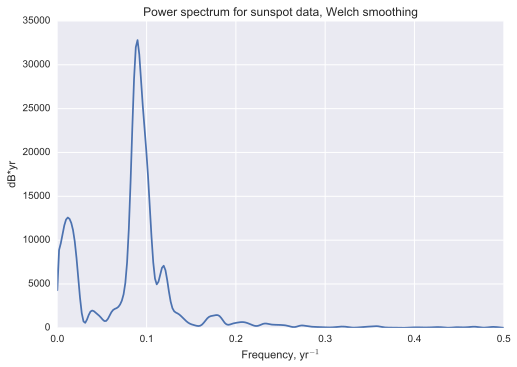

In [31]:
power_x, freq_x = mlab.psd(ss['Sunspots'], 128, Fs=1, detrend=mlab.detrend_mean, pad_to=512, window=mlab.window_hanning, noverlap=64)
plt.plot(freq_x, power_x)
plt.xlabel('Frequency, yr$^{-1}$')
plt.ylabel('dB*yr') #The output is power in dB (decibles) per frequency
plt.title('Power spectrum for sunspot data, Welch smoothing')
plt.show()

Now the two main frequencies are very pronounced!

## Significance Testing
The Fisher's G test is a test of whether a peak in the power spectrum is significantly higher than would be expected from a white noise sample. The following code implements the Fisher G test. Beforehand, the user needs to identify the index corresponding to the frequency of interest. Below I include a line of code to find the index of the maximum freqency in the smoothed sunspot series.

In [32]:
# Find the index of the peak
i = np.argmax(power_x)

# Here is the function that solves for Fisher's G and the p-value.
def fishers_g(Pxx, peak_index): 
    '''
    Fisher's G test for significance of a spectral peak.
    Arguments are Pxx = the complete power spectrum, and peak_index, which
    is the index of the peak for which you would like to test significance.
    Low p-values reject the null hypothesis that the peak is not of higher
    magnitude than expected in a random noise signal.
    '''
    from scipy import misc
    fisher_g = Pxx[i]/np.sum(Pxx) # Test statistic
    N = len(Pxx)
    upper = np.floor(1/fisher_g)
    I = np.zeros(3)
    for nn in range(1,4):
        I[nn-1] = (-1)**(nn-1)*misc.comb(N,nn)*(1-nn*fisher_g)**(N-1)
    pval = np.sum(I)
    return fisher_g, pval
        
g, p = fishers_g(power_x, i)
print(g)
print(p)

0.0529925035927
0.000227188224058


As we might expect, we see that the maximum frequency is highly significant.

## Filtering
Let's say that we wanted to take out all frequencies apart from the two dominant peaks. We can do this by coarsely setting all other frequencies equal to zero and then taking the inverse Fourier transform, as we do below:

//anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


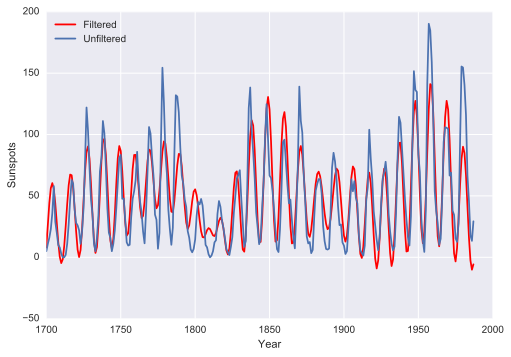

In [33]:
SSf = SS
SSf[np.abs(SS)<1500]=0 #1500 was selected from the stem plot.
TS2 = fftpack.ifft(SSf)+np.mean(ss['Sunspots'])
plt.plot(ss['Year'], TS2, 'r')
plt.plot(ss['Year'], ss['Sunspots'])
plt.xlabel('Year')
plt.ylabel('Sunspots')
plt.legend(['Filtered', 'Unfiltered'], loc=2)
plt.show()

We no longer see any shoulders on peaks, but we do see that we've cut out *a lot* of frequencies, which were needed to modulate the amplitudes of the other dominant frequencies. Often, a more sophisiticated type of filter, such as the Butterworth, is a better choice.

To illustrate this, let's go back to the DOC time series and design a low-pass filter. First, let's take a look at its power spectrum. The length of the DOC array is 480. In order to resolve an annual signal, our block length needs to be at least that large, so we will do an analysis with no overlap but a Hanning window. Here, we will plot the power spectrum on log-log axes.

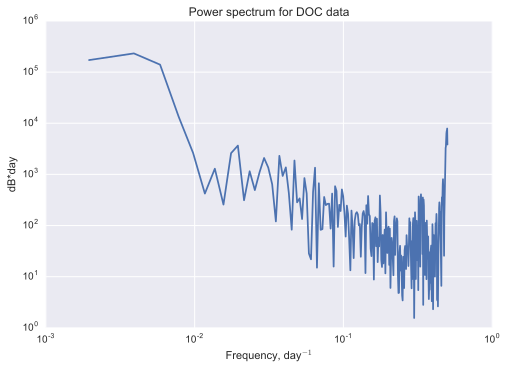

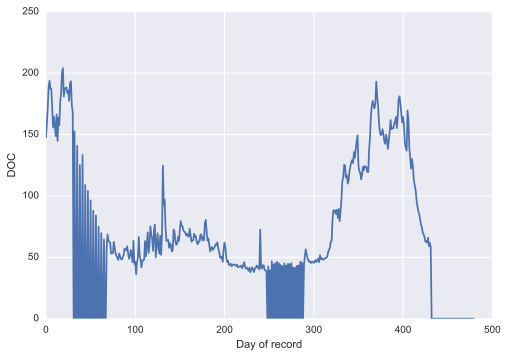

In [34]:
power_x, freq_x = mlab.psd(DOC, 480, Fs=1, detrend=mlab.detrend_mean, pad_to=512, window=mlab.window_hanning, noverlap=0)
plt.loglog(freq_x, power_x)
plt.xlabel('Frequency, day$^{-1}$')
plt.ylabel('dB*day') #The output is power in dB (decibles) per frequency
plt.title('Power spectrum for DOC data')
plt.show()
plt.plot(DOC)
plt.xlabel('Day of record')
plt.ylabel('DOC')
plt.show()

There appears to be a roughly seasonal signal present in this dataset, which is a bit difficult to resolve in a dataset that is just greater than one year. Let's try to remove it by designing a Butterworth filter with a cutoff near 1/30, to allow frequencies longer than monthly freqencies pass through.

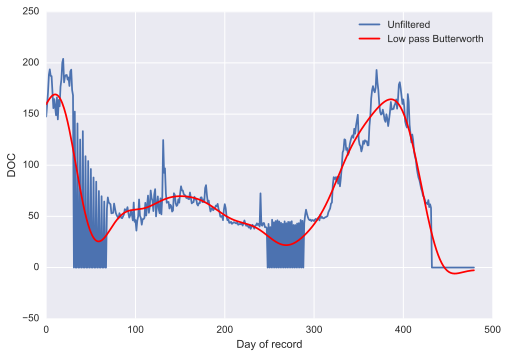

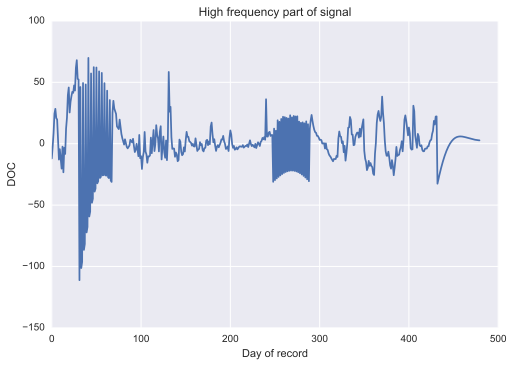

In [35]:
# First, design the Buterworth filter
N  = 4    # Filter order. You can play around with higher orders too!
Wn = 1/30 # Cutoff frequency
B, A = signal.butter(N, Wn, btype = 'lowpass') #When we apply the filter, we'll get just the
    # low frequencies, i.e., the seasonal part of the cycle
 
# Second, apply the filter
seasonal = signal.filtfilt(B,A, DOC)

plt.plot(DOC)
plt.plot(seasonal, 'r-')
plt.ylabel('DOC')
plt.xlabel('Day of record')
plt.legend(['Unfiltered', 'Low pass Butterworth'])
plt.show()

#Now let's look at the high-frequency part of the signal.
high_freqs = DOC-seasonal
plt.plot(high_freqs)
plt.ylabel('DOC')
plt.xlabel('Day of record')
plt.title('High frequency part of signal')
plt.show()

Those "blanks" look awful here! We really should have done something a little more sophisticated to fill the gaps. But that is all for now...